In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

face_cascade = cv2.CascadeClassifier('/home/mckc/Downloads/opencv-2.4.13/data/haarcascades_GPU/haarcascade_frontalface_default.xml')

In [2]:
#Reading the image data into numpy
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:], [0.299, 0.587, 0.114])

def load_data():
    import pandas as pd
    import numpy as np
    from PIL import Image
    
    train = pd.read_csv('/home/mckc/All Data/train.csv')
    test = pd.read_csv('/home/mckc/All Data/test.csv')
    print 'the training data shape is ',train.shape
    print 'the test data shape is ', test.shape
    
    X_tr = np.zeros((1,1944,2592),dtype=np.uint8)
    iteration = 0
    for i in train.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
#     print X_tr.shape,image.shape
        X_tr =  np.vstack((X_tr,image))
        iteration+=1
        if iteration % 50==0:
            print colored((float(iteration)/len(train.values[:,0])*100 ,' Percentage complete'), 'green')
    Y_tr = train.values[:,1]
    X_tr = X_tr[1:,:,:]
    X_ts = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in test.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
        X_ts = np.vstack((X_ts,image))
    Y_ts = test.values[:,1]
    X_ts = X_ts[1:,:,:]
    print 'the training file shape',X_tr.shape,Y_tr.shape
    print 'the testing file shape',X_ts.shape,Y_ts.shape
    
    return X_tr,X_ts,Y_tr,Y_ts    

In [3]:
def simulate(X,Y):
    import scipy as sp
    import scipy.ndimage
    complete = np.zeros((1,96,96),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        complete = np.vstack((complete,X[i,:,:].reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = 15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(X[i,:,:], angle = -10,reshape=False,cval=1).reshape(1,96,96)))
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = 15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -5,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -10,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,scipy.ndimage.rotate(rotated, angle = -15,reshape=False,cval=1).reshape(1,96,96)))
        complete = np.vstack((complete,rotated.reshape(1,96,96)))
        Y_complete = np.append(Y_complete,([Y[i]]*14))
        if i % 10==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [4]:
def extract_faces(X_tr,Y_tr):
    from skimage.transform import resize
    import time
    start_time = time.clock()
    all_faces = np.zeros((1,96,96),dtype=np.uint8)
    missing = []
    multiple = []
    Y= []
    for i in range(len(X_tr)):
        faces  = face_cascade.detectMultiScale(X_tr[i,:,:],scaleFactor=1.3,minNeighbors=5,minSize=(70, 70))
        n_faces = len(faces)
        if n_faces is 1:
            for (x,y,w,h) in faces:
                fac = np.array(X_tr[i,:,:])[y:(y+h),x:(x+h)]
                out = (resize(fac,(96,96))).reshape((1,96,96))
                all_faces = np.vstack((all_faces,out))
                Y = np.append(Y,Y_tr[i])
        else:
            if n_faces > 1:
                #print ('There are multiple faces for index %d and with length %d' % (i , n_faces))
                missing = np.append(missing,i)
                #all_faces = np.vstack((all_faces,np.zeros((1,96,96),dtype=np.uint8)))
            else:
                #print ('The face is missing for index %d' %i)
                multiple = np.append(multiple,i)
        if i % 50==0:
            print colored((float(i)/len(X_tr)*100 ,' Percentage complete'), 'green')

    all_faces = all_faces[1:,:,:]
    print all_faces.shape
    print time.clock() - start_time, "seconds"
    return all_faces,missing,multiple,Y

In [3]:
def load(data):
    import os
    import numpy as np
    files = os.listdir('/home/mckc/all_'+data+'/')    
    X = np.zeros((1,96,96),dtype=np.float64)
    Y = []
    iter = 0
    for i in files:
        X = np.vstack((X,np.load('/home/mckc/all_'+data+'/'+i).reshape(1,96,96)))
        index = i.index('_')
        Y = np.append(Y,i[:index])
        iter = iter+1
        if iter % 250 ==0:
            print colored((float(iter)/len(files)*100 ,' Percentage complete'), 'green')
            
        print X[1:,:,:].shape,Y.shape
    return X[1:,:,:],Y

In [6]:
def Save_data(X,Y,data):
    for i in range(len(X)):
        file_name = '/home/mckc/all_'+data+'/'+Y[i]+'_'+str(i)+'.npy'
        np.save(file_name,X[i,:,:])

In [7]:
X_tr,X_tst,Y_tr,Y_tst = load_data()

the training data shape is  (586, 2)
the test data shape is  (195, 2)
(8.532423208191126, ' Percentage complete')
(17.064846416382252, ' Percentage complete')
(25.597269624573375, ' Percentage complete')
(34.129692832764505, ' Percentage complete')
(42.66211604095563, ' Percentage complete')
(51.19453924914675, ' Percentage complete')
(59.72696245733788, ' Percentage complete')
(68.25938566552901, ' Percentage complete')
(76.79180887372013, ' Percentage complete')
(85.32423208191126, ' Percentage complete')
(93.85665529010238, ' Percentage complete')
the training file shape (586, 1944, 2592) (586,)
the testing file shape (195, 1944, 2592) (195,)


In [8]:
X_train,missing,multiple,Y_train = extract_faces(X_tr[:,:,:],Y_tr)
X_test,missing_test,multiple_test,Y_test = extract_faces(X_tst,Y_tst)

(0.0, ' Percentage complete')
(8.532423208191126, ' Percentage complete')
(17.064846416382252, ' Percentage complete')
(25.597269624573375, ' Percentage complete')
(34.129692832764505, ' Percentage complete')
(42.66211604095563, ' Percentage complete')
(51.19453924914675, ' Percentage complete')
(59.72696245733788, ' Percentage complete')
(68.25938566552901, ' Percentage complete')
(76.79180887372013, ' Percentage complete')
(85.32423208191126, ' Percentage complete')
(93.85665529010238, ' Percentage complete')
(497, 96, 96)
156.646721 seconds
(0.0, ' Percentage complete')
(25.64102564102564, ' Percentage complete')
(51.28205128205128, ' Percentage complete')
(76.92307692307693, ' Percentage complete')
(166, 96, 96)
50.47664 seconds


In [9]:
import time
start_time = time.clock()
X,Y = simulate(X_train,Y_train)
print X.shape,Y.shape
print time.clock() - start_time, "seconds"

(0.0, ' Percentage complete')
(2.0120724346076457, ' Percentage complete')
(4.0241448692152915, ' Percentage complete')
(6.036217303822937, ' Percentage complete')
(8.048289738430583, ' Percentage complete')
(10.06036217303823, ' Percentage complete')
(12.072434607645874, ' Percentage complete')
(14.084507042253522, ' Percentage complete')
(16.096579476861166, ' Percentage complete')
(18.10865191146881, ' Percentage complete')
(20.12072434607646, ' Percentage complete')
(22.132796780684107, ' Percentage complete')
(24.14486921529175, ' Percentage complete')
(26.156941649899395, ' Percentage complete')
(28.169014084507044, ' Percentage complete')
(30.181086519114686, ' Percentage complete')
(32.19315895372233, ' Percentage complete')
(34.205231388329985, ' Percentage complete')
(36.21730382293762, ' Percentage complete')
(38.22937625754527, ' Percentage complete')
(40.24144869215292, ' Percentage complete')
(42.25352112676056, ' Percentage complete')
(44.26559356136821, ' Percentage com

In [10]:
Save_data(X,Y,'train')
Save_data(X_test,Y_test,'test')

In [11]:
import gc
gc.collect()

0

In [14]:
X.shape,Y.shape

((6958, 96, 96), (6958,))

In [6]:
X,Y = load('train')
X_test,Y_test = load('test')
print X.shape,Y.shape
print X_test.shape,Y_test.shape

(3.592986490370796, ' Percentage complete')
(7.185972980741592, ' Percentage complete')
(10.778959471112389, ' Percentage complete')
(14.371945961483185, ' Percentage complete')
(17.964932451853983, ' Percentage complete')
(21.557918942224777, ' Percentage complete')
(25.15090543259557, ' Percentage complete')
(28.74389192296637, ' Percentage complete')
(32.33687841333717, ' Percentage complete')
(35.929864903707966, ' Percentage complete')
(39.52285139407876, ' Percentage complete')
(43.115837884449554, ' Percentage complete')
(46.70882437482035, ' Percentage complete')
(50.30181086519114, ' Percentage complete')
(53.89479735556194, ' Percentage complete')
(57.48778384593274, ' Percentage complete')
(61.08077033630354, ' Percentage complete')
(64.67375682667434, ' Percentage complete')
(68.26674331704513, ' Percentage complete')
(71.85972980741593, ' Percentage complete')
(75.45271629778671, ' Percentage complete')
(79.04570278815751, ' Percentage complete')
(82.6386892785283, ' Perce

In [7]:
def standard(X):
    return (X - X.mean())/X.max()

X_test = standard(X_test)
X = standard(X)

In [8]:
X_normal = X.reshape(-1,9216)
X_test_normal = X_test.reshape(-1,9216)
map, Y_number = np.unique(Y, return_inverse=True)
Y_test_number = np.unique(Y_test, return_inverse=True)[1]

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = LogisticRegression(verbose=0,n_jobs=-1,multi_class='multinomial',solver='lbfgs',max_iter=500,warm_start=True)
clf.fit(X_normal,Y_number)
Y_logictic= clf.predict(X_test.reshape(-1,9216))
Y_log_vales = map[Y_logictic]

print 'Accuracy of the model is ',accuracy_score(Y_test,Y_log_vales)
confusion_matrix(Y_log_vales,Y_test)

Accuracy of the model is  0.975903614458


array([[19,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0],
       [ 0,  1, 26,  0,  0,  0,  0],
       [ 0,  1,  0, 25,  0,  0,  0],
       [ 0,  0,  0,  0, 27,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0],
       [ 0,  1,  0,  0,  0,  1, 33]])

In [10]:
clf.coef_.shape

(7, 9216)

Abhay


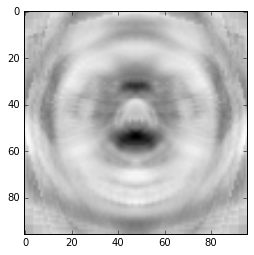

In [11]:
print map[0]
plt.imshow(clf.coef_[0,:].reshape(96,96),cmap=cm.Greys_r)

Arun


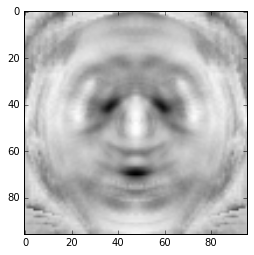

In [12]:
print map[1]
plt.imshow(clf.coef_[1,:].reshape(96,96),cmap=cm.Greys_r)

Gopika


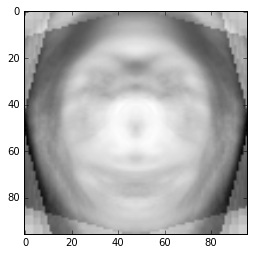

In [13]:
print map[2]
plt.imshow(clf.coef_[2,:].reshape(96,96),cmap=cm.Greys_r)

Kinkar


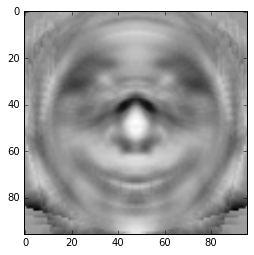

In [14]:
print map[3]
plt.imshow(clf.coef_[3,:].reshape(96,96),cmap=cm.Greys_r)

Omar


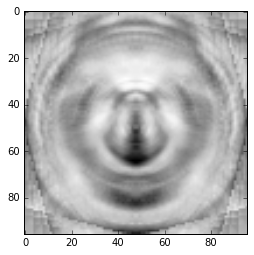

In [15]:
print map[4]
plt.imshow(clf.coef_[4,:].reshape(96,96),cmap=cm.Greys_r)

Pandian


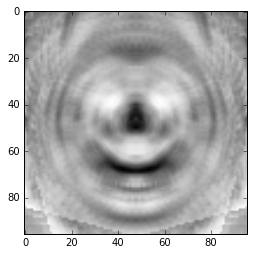

In [16]:
print map[5]
plt.imshow(clf.coef_[5,:].reshape(96,96),cmap=cm.Greys_r)

Sharath


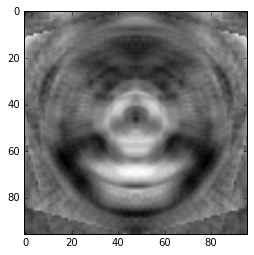

In [17]:
print map[6]
plt.imshow(clf.coef_[6,:].reshape(96,96),cmap=cm.Greys_r)

In [18]:
from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(200,verbose=0,oob_score=True,n_jobs=-1,warm_start=True)
recognizer.fit(X_normal,Y_number)

Y_rf= recognizer.predict(X_test.reshape(-1,9216))
Y_rf_vales = map[Y_rf]

print 'Accuracy of the model is ',accuracy_score(Y_test,Y_rf_vales)
confusion_matrix(Y_test,Y_rf_vales)

Accuracy of the model is  0.975903614458


array([[19,  0,  0,  0,  0,  0,  0],
       [ 1, 17,  1,  0,  0,  0,  0],
       [ 0,  0, 26,  0,  0,  0,  0],
       [ 0,  0,  0, 25,  0,  0,  0],
       [ 1,  0,  0,  0, 26,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  1],
       [ 0,  0,  0,  0,  0,  0, 33]])

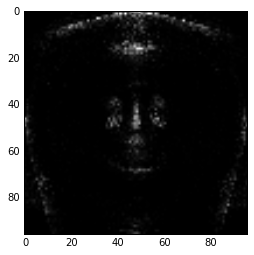

In [19]:
importances = recognizer.feature_importances_
importance_image = importances.reshape(96,96)
#plt.figure(figsize=(7,7))
plt.imshow(importance_image,cmap=cm.Greys_r)

In [1]:
import lasagne
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne import layers
from lasagne.objectives import categorical_crossentropy
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator,visualize,NeuralNet
Conv2DLayer = layers.Conv2DLayer
MaxPool2DLayer = layers.MaxPool2DLayer

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=2,
    
    update = nesterov_momentum,
    update_learning_rate=0.0001,
    update_momentum=0.9,
    max_epochs=500,
    verbose=1
)
net.fit(X.reshape(-1,1,96,96).astype(np.float32), Y_number.astype(np.uint8))

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device gpu failed:
Not able to select available GPU from 1 cards (out of memory).
ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device gpu failed:
Not able to select available GPU from 1 cards (out of memory).


RuntimeError: ('Not able to select available GPU from 1 cards (out of memory).', 'You asked to force this device and it failed. No fallback to the cpu or other gpu device.')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD
from keras.utils import np_utils


Y_Keras = np_utils.to_categorical(Y_number, 2)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=9216,activation='relu'))
model.add(Dense(2,activation='softmax'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

import time
model.fit(X.reshape(-1,9216), Y_Keras, nb_epoch=300, batch_size=5,verbose=1,
         validation_data=(X_test.reshape(-1,9216), np_utils.to_categorical(Y_test_numer, 2)))